In [32]:
import numpy as np
import networkx as nx
import torch
import time
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt
from torch import autograd

In this part, we focus on a simple road map (rep as a graph below), and generate random path on it.
<img src="img/naive_road.png" alt="Drawing" style="width: 400px;"/>

In [33]:
def one_hot(x, N = 24):
    l = np.zeros(24)
    l[x] = 1
    return l
def inv_one_hot(l, N = 24):
    return np.argmax(l)

In [34]:
def build_graph():
    G=nx.Graph()
    G.add_nodes_from(range(24))
    G.add_edges_from([(i, i+1) for i in range(5)] 
                     + [(i+6, i+7) for i in range(5)] 
                     +[(i+12, i+13) for i in range(5)]
                     + [(i+18, i+19) for i in range(5)]
                     + [(0,6),(6,12), (12,18)]
                     + [(pair[0]+1, pair[1]+1) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+2, pair[1]+2) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+3, pair[1]+3) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+4, pair[1]+4) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+5, pair[1]+5) for pair in [(0,6),(6,12), (12,18)]]
                     )
    return G

In [35]:
# gloable env
G = build_graph() 
N = len(G.node)

In [36]:
def random_path(start = None, stop_prob = 0.1):
    """
    Generate random path on graph G with lenght at least 2, encode each road in one-hot fashion
    """
    if not start:
        start = np.random.choice(24)
    path = [start]
    while True:
        nxt = np.random.choice(list(G.neighbors(start)))
        path.append(nxt)
        start = nxt
        if np.random.rand() < stop_prob:
            break
    return np.array(path)

In [37]:
p = random_path()
print(p)

[3 2 3 9 8 7 8 7 8 2 1 0 1 7 6]


In [38]:
def random_training_set():
    def f(x):
        if x == -1:
            return 0
        if x == -6:
            return 1
        if x == 1:
            return 2
        if x == 6:
            return 3
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    #import pdb; pdb.set_trace()
    tar = [f(x) for x in path[1:] - path[:-1]]
    tar = torch.from_numpy(np.array(tar))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [39]:
def random_training_set_with_road_tar():
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    tar = torch.from_numpy(np.array(path[1:]))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [40]:
x,y = random_training_set()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} denotes the turning decistion at each road'.format(y.data.numpy()))

x: [13] is the sequence of road
y: [1] denotes the turning decistion at each road


In [41]:
x,y = random_training_set_with_road_tar()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} is the sequence of road'.format(y.data.numpy()))

x: [14, 8, 2, 3, 4, 5, 4, 3, 4, 3, 9, 10, 9, 10, 9, 3, 2, 1, 2, 1, 2, 3, 2, 8] is the sequence of road
y: [ 8  2  3  4  5  4  3  4  3  9 10  9 10  9  3  2  1  2  1  2  3  2  8  2] is the sequence of road


In [42]:
x.size()

torch.Size([24, 24])

Since we know the road transition are markov (turing decision only depends on current road), let start with *none-recurrent nn* to fit our transition

# Model and Train

In [43]:
N_batch, D_in, D_hidden, D_out = 50, 24, 100, 4
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(D_hidden, D_out),
    torch.nn.Softmax(dim = 1),
)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = 0
n = 0
pts = {'x':[], 'y':[]}
for t in range(1,10001):
    x,y = random_training_set()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    L += sum(loss.data.numpy())
    n += len(loss.data.numpy())
    if t%1000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/n)
        print(t, L/n)
        L = 0
        n = 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


1000 1.35423036337
2000 1.33368456709
3000 1.33338143724
4000 1.32994685966
5000 1.32924786431
6000 1.32996935713
7000 1.32879956979
8000 1.32648307264
9000 1.32783744538
10000 1.32709991968


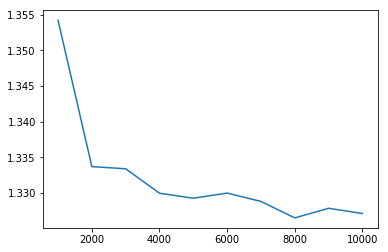

In [44]:
plt.plot(pts['x'],pts['y'])

# Testing

In [45]:
x,y = random_training_set()
print([inv_one_hot(r) for r in x.data.numpy()])
model(x)

[22, 21, 15, 21, 20, 19, 20, 21, 15, 9, 10, 16, 22]


Variable containing:
 0.2746  0.4462  0.2775  0.0017
 0.4033  0.4163  0.1786  0.0018
 0.2551  0.2861  0.2197  0.2390
 0.4033  0.4163  0.1786  0.0018
 0.4116  0.2907  0.2958  0.0019
 0.3504  0.3832  0.2648  0.0015
 0.4116  0.2907  0.2958  0.0019
 0.4033  0.4163  0.1786  0.0018
 0.2551  0.2861  0.2197  0.2390
 0.1743  0.3672  0.1987  0.2598
 0.2040  0.3705  0.1946  0.2309
 0.2524  0.3073  0.2552  0.1851
 0.2746  0.4462  0.2775  0.0017
[torch.FloatTensor of size 13x4]